### Genetic Algorithm for finding interaction coefficients for randomly generated 2D lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
e_x = 10*(np.random.rand(2)*2 -1)  
e_y = 10*(np.random.rand(2)*2 -1)   
print("fixed basis vectors:")
print("e_x:", e_x)
print("e_y:", e_y)

Fixed basis vectors:
e_x: [-4.07968904 -2.00883304]
e_y: [5.45008752 4.60367014]


Best set of eta coefficients: [ 0.9725358   0.97293074  0.26986984  0.51483321  0.326583   -0.64798267
  0.15892132]
Fitness of best solution: 0.3607580579662667
First excited state decoded coordinates: (-2, -1)
Length of the vector: 2.7719408559780714


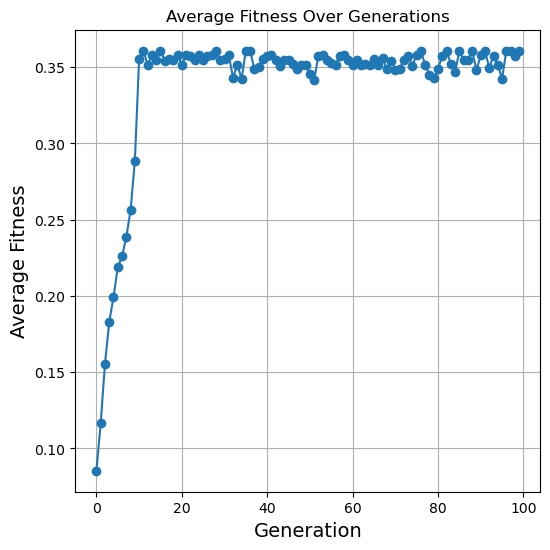

In [3]:
def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_hamiltonian(num_qubits, coefficients, mu):
    H = np.zeros((2**num_qubits, 2**num_qubits))
    for i, coeff in enumerate(coefficients):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        ops[i + 1] = pauli_z()
        H += coeff * tensor_product(ops)
    
    for i in range(num_qubits - 1):  
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        H += mu * tensor_product(ops)
    
    return H

def compute_eigenvalues_and_eigenvectors(H):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def order_eigenvectors_by_energy(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def decode_eigenvector_signed_magnitude(index, num_bits_per_coordinate):
    binary_str = format(index, f'0{2 * num_bits_per_coordinate}b')
    x_bin = binary_str[:num_bits_per_coordinate]
    y_bin = binary_str[num_bits_per_coordinate:]
    
    def signed_magnitude_decode(bin_str):
        sign = int(bin_str[0])
        magnitude = int(bin_str[1:], 2)
        return magnitude if sign == 0 else -magnitude
    
    x = signed_magnitude_decode(x_bin)
    y = signed_magnitude_decode(y_bin)
    
    return (x, y)

def calculate_vector_length(decoded_coordinates, e_x, e_y):
    a, b = decoded_coordinates
    v = a * e_x + b * e_y
    return np.linalg.norm(v)

## GENETIC ALG ##

def initialize_population(population_size, num_genes):
    population = np.random.uniform(-1, 1, (population_size, num_genes))
    # ensure all sign combinations are unique initially
    for i in range(population_size):
        signs = np.random.choice([-1, 1], size=num_genes)
        population[i] *= signs
    return population

def select_parents(population, fitness, num_parents):
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.argmax(fitness)
        parents[i, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -np.inf  # so that this parent is not selected again
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
    
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring, mutation_rate):
    for idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                # 50% chance to flip sign or add small value
                if np.random.rand() > 0.5:
                    offspring[idx, gene_idx] *= -1 
                else:
                    random_value = np.random.uniform(-1.0, 1.0)
                    offspring[idx, gene_idx] += random_value
    return offspring

def fitness_function(coefficients):
    H = construct_hamiltonian(num_qubits, coefficients, mu)
    eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
    sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
    first_excited_eigenvector = sorted_eigenvectors[:, 1]
    index = np.argmax(np.abs(first_excited_eigenvector))
    decoded_coordinates = decode_eigenvector_signed_magnitude(index, num_bits_per_coordinate=4)
    vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)
    
    if vector_length == 0:
        return 1e-6  # assign a very small fitness for zero-length vectors
    return 1 / vector_length  # minimise the vector length


num_qubits = 8  
population_size = 100  # adjust based on resources and complexity
num_generations = 100
num_genes = 7
num_parents = population_size // 2
mutation_rate = 0.01  # initial mutation rate
mu = 0.0001  # strength parameter for the additional Pauli-Z term

population = initialize_population(population_size, num_genes)
best_solution = None
best_fitness = float('-inf')

average_fitness_per_generation = []

for generation in range(num_generations):
    fitness = np.array([fitness_function(ind) for ind in population])
    
    # filter out zero-length vectors for average fitness calculation
    valid_fitness = fitness[fitness > 1e-6]
    
    if len(valid_fitness) == 0:
        print("All fitness values are zero-length vectors. Something might be wrong.")
        break
    
    parents = select_parents(population, fitness, num_parents)
    offspring_crossover = crossover(parents, (population_size - parents.shape[0], num_genes))
    offspring_mutation = mutation(offspring_crossover, mutation_rate)
    population[:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation

    # elitism, keep the best solution
    max_fitness_idx = np.argmax(fitness)
    if fitness[max_fitness_idx] > best_fitness:
        best_fitness = fitness[max_fitness_idx]
        best_solution = population[max_fitness_idx, :]

    # calculate and store the average fitness for this generation
    average_fitness = np.mean(valid_fitness)
    average_fitness_per_generation.append(average_fitness)

print(f"Best set of eta coefficients: {best_solution}")
print(f"Fitness of best solution: {best_fitness}")

# verify the best solution
H = construct_hamiltonian(num_qubits, best_solution, mu)
eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
first_excited_eigenvector = sorted_eigenvectors[:, 1]
index = np.argmax(np.abs(first_excited_eigenvector))
decoded_coordinates = decode_eigenvector_signed_magnitude(index, num_bits_per_coordinate=4)
vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)

print(f"First excited state decoded coordinates: {decoded_coordinates}")
print(f"Length of the vector: {vector_length}")

# plot average fitness over generations
plt.figure(figsize=(6, 6))
plt.plot(range(num_generations), average_fitness_per_generation, marker='o')
plt.xlabel('Generation', fontsize=14)
plt.ylabel('Average Fitness', fontsize=14)
plt.title('Average Fitness Over Generations')
plt.grid(True)
plt.show()